In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from datetime import date, timedelta
from scipy import stats
import scipy.optimize as sco
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
symbol = pd.read_csv("nasdaq_stocks.csv")
symbol_dict = dict(zip(symbol["Name"], symbol["Symbol"]))
#stocks = ["Apple Inc.", "Amazon.com Inc.", "Alphabet Inc.", "Netflix Inc.", "Tesla Inc."]
stocks = random.sample(list(symbol_dict.keys()), 10)
stocks = [symbol_dict[i] for i in stocks]

In [3]:
stocks

['SATS', 'PIRS', 'SRDX', 'MX', 'NRIX', 'MRACW', 'OCG', 'GMED', 'CLDT', 'LVRA']

In [4]:
data = pdr.get_data_yahoo(stocks, start=date.today()-timedelta(365*6), end=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  10 of 10 completed

4 Failed downloads:
- LVRA: Data doesn't exist for startDate = 1436639400, endDate = 1594319400
- NRIX: Data doesn't exist for startDate = 1436639400, endDate = 1594319400
- MRACW: Data doesn't exist for startDate = 1436639400, endDate = 1594319400
- OCG: Data doesn't exist for startDate = 1436639400, endDate = 1594319400


In [5]:
list(set(data.columns) - set(data.dropna(axis=1).columns))

['LVRA', 'MRACW', 'OCG', 'NRIX']

In [6]:
data = data.dropna(axis=1)

In [7]:
data

,CLDT,GMED,MX,PIRS,SATS,SRDX
Date,,,,,,
2015-07-13,20.583122,25.820000,7.99,2.58,39.027554,23.990000
2015-07-14,20.612518,26.080000,8.57,2.61,38.784443,24.219999
2015-07-15,20.612518,26.309999,8.60,2.55,38.784443,23.889999
2015-07-16,21.082825,26.840000,8.40,2.65,39.124798,24.190001
2015-07-17,21.060774,26.870001,8.46,2.72,38.865479,24.280001
...,...,...,...,...,...,...
2020-07-02,5.910000,49.160000,10.22,3.06,26.459999,43.000000
2020-07-06,6.050000,45.599998,10.34,3.23,26.450001,42.639999
2020-07-07,5.620000,45.259998,10.07,3.32,25.420000,42.119999


In [8]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(252)
    return std, returns

def neg_prob_sharpe_ratio(weights, mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (p_ret - risk_free_rate)/p_var
    coskew = pd.Series(stats.skew(mean_returns), index=mean_returns.index).mean()
    cokurt = pd.Series(stats.kurtosis(mean_returns, fisher=False), index=mean_returns.index).mean()    
    sharpe_ratio_stdev = np.sqrt((1+(0.5*sharpe_ratio**2) - coskew*sharpe_ratio) + (((cokurt-3)/4)*sharpe_ratio**2))/(len(mean_returns)-1)
    prob_sharpe_ratio = stats.norm.cdf((sharpe_ratio - sharpe_ratio_benchmark)/sharpe_ratio_stdev)
    return -1*prob_sharpe_ratio

def max_sharpe_ratio(mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_prob_sharpe_ratio, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({"type": "eq", "fun": lambda x: portfolio_return(x) - target}, {"type": "eq", "fun": lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method="SLSQP", bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [9]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.0178
log_returns = np.log(data/data.shift(1))
log_returns = log_returns.dropna()

In [10]:
max_sharpe = max_sharpe_ratio(mean_returns, log_returns, cov_matrix, risk_free_rate, sharpe_ratio_benchmark=1.0)
sdp, rp = portfolio_annualized_performance(max_sharpe["x"], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe["x"], index=data.columns, columns=["allocation"])
max_sharpe_allocation["allocation"] = [round(i*100, 2)for i in max_sharpe_allocation["allocation"]]
max_sharpe_allocation = max_sharpe_allocation.T

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualized_performance(min_vol["x"], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=["allocation"])
min_vol_allocation["allocation"] = [round(i*100,2)for i in min_vol_allocation["allocation"]]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns)*np.sqrt(252)
an_rt = mean_returns*252

In [11]:
print("\nMaximum Sharpe Ratio Portfolio Allocation")
print("Annualized Return:", round(rp, 2))
print("Annualized Volatility:", round(sdp, 2))
print(max_sharpe_allocation)

print("\nMinimum Volatility Portfolio Allocation")
print("Annualized Return:", round(rp_min, 2))
print("Annualized Volatility:", round(sdp_min, 2))
print(min_vol_allocation)

print("\nIndividual Stock Returns and Volatility")
for i, txt in enumerate(data.columns):
    print("{}: Annualized Return: {}; Annualized Volatility: {}".format(txt, round(an_rt[i], 2), round(an_vol[i], 2)))


Maximum Sharpe Ratio Portfolio Allocation
Annualized Return: 0.21
Annualized Volatility: 0.3
            CLDT   GMED     MX   PIRS  SATS   SRDX
allocation   0.0  42.71  15.26  15.44   0.0  26.58

Minimum Volatility Portfolio Allocation
Annualized Return: 0.07
Annualized Volatility: 0.25
            CLDT   GMED    MX  PIRS   SATS   SRDX
allocation   0.0  35.79  4.03  1.84  47.71  10.62

Individual Stock Returns and Volatility
CLDT: Annualized Return: -0.16; Annualized Volatility: 0.46
GMED: Annualized Return: 0.17; Annualized Volatility: 0.33
MX: Annualized Return: 0.22; Annualized Volatility: 0.57
PIRS: Annualized Return: 0.32; Annualized Volatility: 0.78
SATS: Annualized Return: -0.05; Annualized Volatility: 0.3
SRDX: Annualized Return: 0.2; Annualized Volatility: 0.43


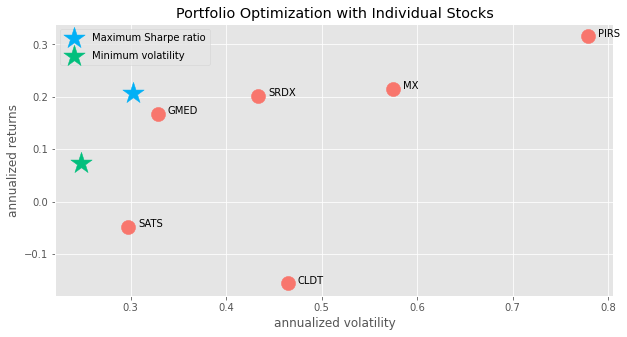

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(an_vol, an_rt, marker="o", color="#f8766d", s=200)

for i, txt in enumerate(data.columns):
    ax.annotate(txt, (an_vol[i], an_rt[i]), xytext=(10, 0), textcoords="offset points")

ax.scatter(sdp, rp, marker="*", color="#01b0f6", s=500, label="Maximum Sharpe ratio")
ax.scatter(sdp_min, rp_min, marker="*", color="#02bf7d", s=500, label="Minimum volatility")

#target = np.linspace(rp_min, 0.34, 50)
#efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

#ax.plot([pf["fun"] for pf in efficient_portfolios], target, linestyle="-.", color="black", label="efficient frontier")
ax.set_title("Portfolio Optimization with Individual Stocks")
ax.set_xlabel("annualized volatility")
ax.set_ylabel("annualized returns")
ax.legend(labelspacing=0.8)
plt.show(fig)

In [13]:
df_test = pdr.get_data_yahoo(list(data.columns), start=date.today()-timedelta(365))["Adj Close"]

[*********************100%***********************]  6 of 6 completed


In [14]:
ret_sharpe = 0
for i in df_test.columns:
    ret_sharpe += df_test[i]*max_sharpe_allocation.reset_index(drop=True)[i][0]
ret_sharpe /= 100

ret_vol = 0
for i in df_test.columns:
    ret_vol += df_test[i]*min_vol_allocation.reset_index(drop=True)[i][0]
ret_vol /= 100

In [15]:
df_test["MSP"] = ret_sharpe
df_test["MVP"] = ret_vol

In [16]:
if df_test.isna().sum().sum() > 0:
    df_test = df_test.dropna()

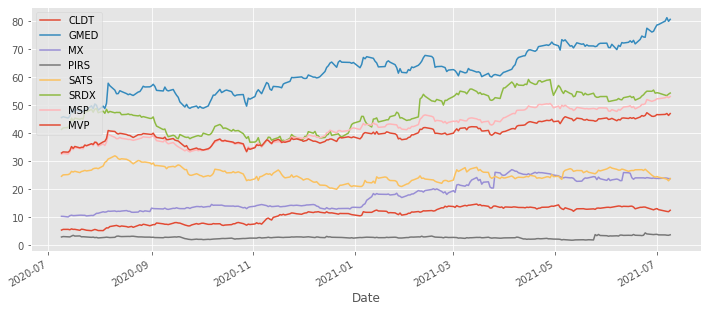

In [17]:
df_test.plot(figsize=(12,5),legend=True)
plt.show()

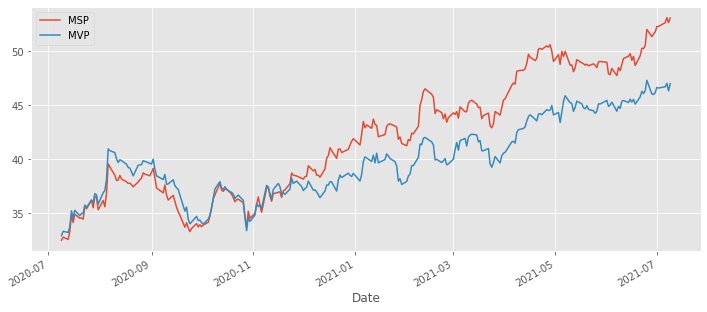

In [18]:
df_test[["MSP", "MVP"]].plot(figsize=(12,5),legend=True)
plt.show()

In [19]:
(df_test["MSP"][-1] - df_test["MSP"][0])/df_test["MSP"][0] * 100

63.41681440342213

In [20]:
(df_test["MVP"][-1] - df_test["MVP"][0])/df_test["MVP"][0] * 100

42.796226589983995

In [21]:
df_test

,CLDT,GMED,MX,PIRS,SATS,SRDX,MSP,MVP
Date,,,,,,,,
2020-07-09,5.38,45.570000,10.290000,2.91,24.580000,41.330002,32.468019,32.894098
2020-07-10,5.62,45.849998,10.270000,3.06,25.080000,41.860001,32.748589,33.291099
2020-07-13,5.63,45.389999,10.070000,2.94,25.190001,42.000000,32.540287,33.183547
2020-07-14,5.48,46.009998,10.510000,2.93,25.480000,43.529999,33.277362,33.723837
2020-07-15,5.80,48.430000,10.690000,3.22,26.330000,45.330002,34.861630,35.199241
...,...,...,...,...,...,...,...,...
2021-07-02,12.67,78.760002,23.799999,3.66,24.270000,54.320000,52.273637,46.562690
2021-07-06,12.15,80.000000,23.950001,3.64,23.740000,53.540001,52.615718,46.676463
2021-07-07,12.03,81.220001,23.920000,3.55,23.549999,53.410000,53.083752,47.005781
